#  2 unit number

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
%matplotlib inline

In [3]:
x, y = load_digits(return_X_y=True)
x.shape, y.shape, set(y)

((1797, 64), (1797,), {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

## print first data

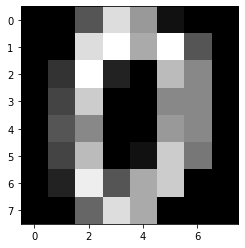

In [4]:
x0 = x[0].astype(np.uint8).reshape((8,8))
plt.imshow(x0, cmap='gray')

##  data concate sample

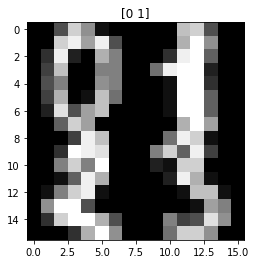

In [9]:
xx0 = np.concatenate((x[0].reshape((8,8)), x[1].reshape((8,8))), axis=1)
xx1 = np.concatenate((x[2].reshape((8,8)), x[3].reshape((8,8))), axis=1)
xx_0_1 = np.concatenate((xx0, xx1), axis=0)
yy0 = y[:2]
yy1 = y[2:4]
plt.title(str(yy0))
plt.imshow(xx_0_1, cmap='gray')

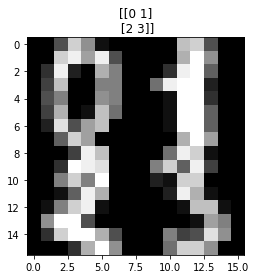

In [16]:
x_train = np.stack((xx0, xx1), 0)
y_train = np.stack((yy0, yy1), 0)
plt.title(str(y_train))
print_x = x_train.reshape((-1, 16))
plt.imshow(print_x, cmap='gray')

In [80]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.opt = tf.optimizers.Nadam()
        self.conv0 = keras.layers.Conv2D(64, [3,3], padding='same', input_shape=(8,8,1), activation=keras.activations.elu)
        self.conv1 = keras.layers.Conv2D(128, [3,3], padding='same', activation=keras.activations.elu)
        self.pool0 = keras.layers.MaxPool2D([2,2], padding='same')
        self.pool1 = keras.layers.MaxPool2D([2,2], padding='same')
        self.flatten = keras.layers.Flatten()
        self.drop0 = keras.layers.Dropout(0.5)
        self.drop1 = keras.layers.Dropout(0.5)
        self.batch0 = keras.layers.BatchNormalization()
        self.batch1 = keras.layers.BatchNormalization()
        self.dense0 = keras.layers.Dense(64, activation=keras.activations.elu)
        self.dense1 = keras.layers.Dense(units=10*2, activation=keras.activations.softmax)
        
    def call(self, x):
        x_4d = tf.reshape(x, [-1,8,8*2,1]) # 두자릿수므로 8*2(16)
        x_4d = tf.cast(x_4d, tf.float32)
        net = self.conv0(x_4d)
        net = self.batch0(net)
        net = self.pool0(net)
        net = self.drop0(net)
        net = self.conv1(net)
        net = self.batch1(net)
        net = self.pool1(net)
        net = self.drop1(net)
        net = self.flatten(net)
        h = self.dense1(net)
        h = tf.reshape(h, [-1, 2, 10])
        h = tf.nn.softmax(h, axis=2)
        return h
    
    def get_loss(self, y, h):
        h = tf.clip_by_value(h, 1e-8, 1- 1e-8)
        cross_entropy = - (y * tf.math.log(h) + (1-y) * tf.math.log(1-h))
        loss = tf.reduce_mean(cross_entropy)
        return loss
    
    def get_accuracy(self, y, h):
        predict = tf.argmax(h, -1)
        is_equal = tf.equal(y, predict)
        self.acc = tf.reduce_mean(tf.cast(tf.equal(y, predict), tf.float32))
        self.acc_all = tf.reduce_mean(tf.cast(tf.reduce_all(is_equal, axis=1), tf.float32))
        
    def fit(self, x, y, epoch=1):
        'x : (m, 8, 16), y : (m, 2)'
        y_hot = tf.one_hot(y, depth=10, axis=-1)
        y_hot = tf.cast(y_hot, tf.float32)
        for i in range(epoch):
            with tf.GradientTape() as tape:
                h = self.call(x)
                loss = self.get_loss(y_hot, h)
            grads = tape.gradient(loss, self.trainable_variables) # 경사 계산
            self.opt.apply_gradients(zip(grads, self.trainable_variables)) # 가중치에서 경사 빼기
            self.get_accuracy(y, h)
            if i % 10 == 0:
                print(f'{i}/{epoch} loss: {loss} acc: {self.acc} acc_all: {self.acc_all}')

## Data split

In [25]:
def concat(x0, x1):
    x0 = x0.astype(np.uint8).reshape((8,8))
    x1 = x1.astype(np.uint8).reshape((8,8))
    
    result = np.concatenate((x0.reshape((8,8)), x1.reshape((8,8))), axis=1)
    return result

In [74]:
length = len(x) // 2
x_train, x_test = x[:length], x[length:length*2]
y_train, y_test = y[:length], y[length:length*2]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((898, 64), (898,), (898, 64), (898,))

In [75]:
x_train_list = []
y_train_list = []

for i in range(length):
    for j in range(length):
        xx = concat(x_train[i],x_train[j])
        xx = xx.tolist()
        x_train_list.append(xx)
        y_train_list.append([y_train[i], y_train[j]])
x_train = np.array(x_train_list)
y_train = np.array(y_train_list)

In [76]:
x_test_list = []
y_test_list = []

for i in range(length):
    for j in range(length):
        xx = concat(x_test[i],x_test[j])
        xx = xx.tolist()
        x_test_list.append(xx)
        y_test_list.append([y_test[i], y_test[j]])
x_test = np.array(x_test)
y_test = np.array(y_test)

In [77]:
x_temp = x_train[:10000]
y_temp = y_train[:10000]
x_temp.shape, y_temp.shape

((10000, 8, 16), (10000, 2))

In [81]:
model = MyModel()
model.fit(x_temp, y_temp, epoch=100)

0/100 loss: 0.3255101442337036 acc: 0.1137000024318695 acc_all: 0.01269999984651804
10/100 loss: 0.31780216097831726 acc: 0.23010000586509705 acc_all: 0.03350000083446503
20/100 loss: 0.3034556210041046 acc: 0.2997500002384186 acc_all: 0.05590000003576279
30/100 loss: 0.294892817735672 acc: 0.4560000002384186 acc_all: 0.2078000009059906
40/100 loss: 0.2923295199871063 acc: 0.5325499773025513 acc_all: 0.28790000081062317
50/100 loss: 0.28912511467933655 acc: 0.5190500020980835 acc_all: 0.2676999866962433
60/100 loss: 0.2841586768627167 acc: 0.6106500029563904 acc_all: 0.3580000102519989
70/100 loss: 0.2836011052131653 acc: 0.6132500171661377 acc_all: 0.3619000017642975
80/100 loss: 0.2834821939468384 acc: 0.6143500208854675 acc_all: 0.3637000024318695
90/100 loss: 0.2834216058254242 acc: 0.6144499778747559 acc_all: 0.36390000581741333


simple split

In [42]:
x_train = np.reshape(x_train, [length//2, -1])
y_train = np.reshape(y_train, [length//2, 2])
x_test = np.reshape(x_test, [length//2, -1])
y_test = np.reshape(y_test, [length//2, 2])
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((449, 128), (449, 2), (449, 128), (449, 2))

In [68]:
model = MyModel()

In [70]:
model.fit(x_train, y_train, epoch=5000)

0/5000 loss: 0.2765684127807617 acc: 0.7683741450309753 acc_all: 0.5523385405540466
1/5000 loss: 0.2765682637691498 acc: 0.7683741450309753 acc_all: 0.5523385405540466
2/5000 loss: 0.27656805515289307 acc: 0.769487738609314 acc_all: 0.5545657277107239
3/5000 loss: 0.27656784653663635 acc: 0.769487738609314 acc_all: 0.5545657277107239
4/5000 loss: 0.27656763792037964 acc: 0.7683741450309753 acc_all: 0.5523385405540466
5/5000 loss: 0.2765674889087677 acc: 0.7683741450309753 acc_all: 0.5523385405540466
6/5000 loss: 0.2765672206878662 acc: 0.7683741450309753 acc_all: 0.5523385405540466
7/5000 loss: 0.2765670716762543 acc: 0.7683741450309753 acc_all: 0.5523385405540466
8/5000 loss: 0.27656692266464233 acc: 0.7683741450309753 acc_all: 0.5523385405540466
9/5000 loss: 0.27656668424606323 acc: 0.7683741450309753 acc_all: 0.5523385405540466
10/5000 loss: 0.2765665650367737 acc: 0.7683741450309753 acc_all: 0.5523385405540466
11/5000 loss: 0.27656635642051697 acc: 0.7683741450309753 acc_all: 0.552

98/5000 loss: 0.2765555679798126 acc: 0.7750557065010071 acc_all: 0.5657015442848206
99/5000 loss: 0.2765554189682007 acc: 0.7750557065010071 acc_all: 0.5657015442848206
100/5000 loss: 0.2765553891658783 acc: 0.7750557065010071 acc_all: 0.5657015442848206
101/5000 loss: 0.27655524015426636 acc: 0.7761692404747009 acc_all: 0.5679287314414978
102/5000 loss: 0.27655521035194397 acc: 0.7761692404747009 acc_all: 0.5679287314414978
103/5000 loss: 0.2765550911426544 acc: 0.7761692404747009 acc_all: 0.5679287314414978
104/5000 loss: 0.27655500173568726 acc: 0.7750557065010071 acc_all: 0.5657015442848206
105/5000 loss: 0.2765549123287201 acc: 0.7750557065010071 acc_all: 0.5657015442848206
106/5000 loss: 0.27655479311943054 acc: 0.7750557065010071 acc_all: 0.5657015442848206
107/5000 loss: 0.27655479311943054 acc: 0.7750557065010071 acc_all: 0.5657015442848206
108/5000 loss: 0.2765547037124634 acc: 0.7750557065010071 acc_all: 0.5657015442848206
109/5000 loss: 0.2765546143054962 acc: 0.7750557065

194/5000 loss: 0.2765485942363739 acc: 0.7795100212097168 acc_all: 0.5746102333068848
195/5000 loss: 0.2765485346317291 acc: 0.7795100212097168 acc_all: 0.5746102333068848
196/5000 loss: 0.27654850482940674 acc: 0.7795100212097168 acc_all: 0.5746102333068848
197/5000 loss: 0.27654847502708435 acc: 0.7795100212097168 acc_all: 0.5746102333068848
198/5000 loss: 0.2765483558177948 acc: 0.7795100212097168 acc_all: 0.5746102333068848
199/5000 loss: 0.27654826641082764 acc: 0.7795100212097168 acc_all: 0.5746102333068848
200/5000 loss: 0.27654823660850525 acc: 0.7795100212097168 acc_all: 0.5746102333068848
201/5000 loss: 0.2765481472015381 acc: 0.7795100212097168 acc_all: 0.5746102333068848
202/5000 loss: 0.2765480577945709 acc: 0.7795100212097168 acc_all: 0.5746102333068848
203/5000 loss: 0.2765480577945709 acc: 0.7795100212097168 acc_all: 0.5746102333068848
204/5000 loss: 0.27654796838760376 acc: 0.7806236147880554 acc_all: 0.576837420463562
205/5000 loss: 0.27654793858528137 acc: 0.78062361

290/5000 loss: 0.2765430212020874 acc: 0.7806236147880554 acc_all: 0.576837420463562
291/5000 loss: 0.27654293179512024 acc: 0.7806236147880554 acc_all: 0.576837420463562
292/5000 loss: 0.27654287219047546 acc: 0.7806236147880554 acc_all: 0.576837420463562
293/5000 loss: 0.2765427827835083 acc: 0.7806236147880554 acc_all: 0.576837420463562
294/5000 loss: 0.27654269337654114 acc: 0.7806236147880554 acc_all: 0.576837420463562
295/5000 loss: 0.27654269337654114 acc: 0.7806236147880554 acc_all: 0.576837420463562
296/5000 loss: 0.27654266357421875 acc: 0.7806236147880554 acc_all: 0.576837420463562
297/5000 loss: 0.276542603969574 acc: 0.7806236147880554 acc_all: 0.576837420463562
298/5000 loss: 0.2765425443649292 acc: 0.7806236147880554 acc_all: 0.576837420463562
299/5000 loss: 0.2765424847602844 acc: 0.7806236147880554 acc_all: 0.576837420463562
300/5000 loss: 0.27654239535331726 acc: 0.7806236147880554 acc_all: 0.576837420463562
301/5000 loss: 0.27654239535331726 acc: 0.7806236147880554 a

387/5000 loss: 0.2765374481678009 acc: 0.7828508019447327 acc_all: 0.5812917351722717
388/5000 loss: 0.2765374183654785 acc: 0.7828508019447327 acc_all: 0.5812917351722717
389/5000 loss: 0.27653738856315613 acc: 0.7828508019447327 acc_all: 0.5812917351722717
390/5000 loss: 0.2765372693538666 acc: 0.7828508019447327 acc_all: 0.5812917351722717
391/5000 loss: 0.2765372395515442 acc: 0.7828508019447327 acc_all: 0.5812917351722717
392/5000 loss: 0.276537150144577 acc: 0.7828508019447327 acc_all: 0.5812917351722717
393/5000 loss: 0.27653712034225464 acc: 0.7828508019447327 acc_all: 0.5812917351722717
394/5000 loss: 0.27653706073760986 acc: 0.7828508019447327 acc_all: 0.5812917351722717
395/5000 loss: 0.2765370011329651 acc: 0.7828508019447327 acc_all: 0.5812917351722717
396/5000 loss: 0.2765370011329651 acc: 0.7828508019447327 acc_all: 0.5812917351722717
397/5000 loss: 0.2765369415283203 acc: 0.7828508019447327 acc_all: 0.5812917351722717
398/5000 loss: 0.27653685212135315 acc: 0.7828508019

482/5000 loss: 0.2765328288078308 acc: 0.7828508019447327 acc_all: 0.5812917351722717
483/5000 loss: 0.2765327990055084 acc: 0.7828508019447327 acc_all: 0.5812917351722717
484/5000 loss: 0.2765327990055084 acc: 0.7828508019447327 acc_all: 0.5812917351722717
485/5000 loss: 0.27653270959854126 acc: 0.7828508019447327 acc_all: 0.5812917351722717
486/5000 loss: 0.2765326499938965 acc: 0.7828508019447327 acc_all: 0.5812917351722717
487/5000 loss: 0.2765326499938965 acc: 0.7828508019447327 acc_all: 0.5812917351722717
488/5000 loss: 0.2765325903892517 acc: 0.7828508019447327 acc_all: 0.5812917351722717
489/5000 loss: 0.27653247117996216 acc: 0.7828508019447327 acc_all: 0.5812917351722717
490/5000 loss: 0.27653244137763977 acc: 0.7828508019447327 acc_all: 0.5812917351722717
491/5000 loss: 0.27653244137763977 acc: 0.7828508019447327 acc_all: 0.5812917351722717
492/5000 loss: 0.2765323221683502 acc: 0.7828508019447327 acc_all: 0.5812917351722717
493/5000 loss: 0.2765323221683502 acc: 0.782850801

579/5000 loss: 0.2762397229671478 acc: 0.788418710231781 acc_all: 0.5857461094856262
580/5000 loss: 0.27593353390693665 acc: 0.7861915230751038 acc_all: 0.5723830461502075
581/5000 loss: 0.27605393528938293 acc: 0.7728285193443298 acc_all: 0.5456570386886597
582/5000 loss: 0.27653539180755615 acc: 0.7772828340530396 acc_all: 0.570155918598175
583/5000 loss: 0.27650442719459534 acc: 0.781737208366394 acc_all: 0.576837420463562
584/5000 loss: 0.2764492928981781 acc: 0.7861915230751038 acc_all: 0.583518922328949
585/5000 loss: 0.27630603313446045 acc: 0.7850779294967651 acc_all: 0.5790646076202393
586/5000 loss: 0.2760283350944519 acc: 0.7928730249404907 acc_all: 0.5902004241943359
587/5000 loss: 0.2757876217365265 acc: 0.7928730249404907 acc_all: 0.5857461094856262
588/5000 loss: 0.27581846714019775 acc: 0.7728285193443298 acc_all: 0.5456570386886597
589/5000 loss: 0.275860071182251 acc: 0.795100212097168 acc_all: 0.5902004241943359
590/5000 loss: 0.275784432888031 acc: 0.775055706501007

675/5000 loss: 0.27567097544670105 acc: 0.8006681799888611 acc_all: 0.6013363003730774
676/5000 loss: 0.2756709158420563 acc: 0.8006681799888611 acc_all: 0.6013363003730774
677/5000 loss: 0.2756708264350891 acc: 0.8006681799888611 acc_all: 0.6013363003730774
678/5000 loss: 0.27567073702812195 acc: 0.8006681799888611 acc_all: 0.6013363003730774
679/5000 loss: 0.2756706178188324 acc: 0.8006681799888611 acc_all: 0.6013363003730774
680/5000 loss: 0.2756705582141876 acc: 0.8006681799888611 acc_all: 0.6013363003730774
681/5000 loss: 0.2756703794002533 acc: 0.8006681799888611 acc_all: 0.6013363003730774
682/5000 loss: 0.2756703197956085 acc: 0.8006681799888611 acc_all: 0.6013363003730774
683/5000 loss: 0.27567026019096375 acc: 0.8006681799888611 acc_all: 0.6013363003730774
684/5000 loss: 0.2756701707839966 acc: 0.8006681799888611 acc_all: 0.6013363003730774
685/5000 loss: 0.27567005157470703 acc: 0.8006681799888611 acc_all: 0.6013363003730774
686/5000 loss: 0.2756699025630951 acc: 0.800668179

769/5000 loss: 0.27566230297088623 acc: 0.7917594909667969 acc_all: 0.583518922328949
770/5000 loss: 0.27566227316856384 acc: 0.7917594909667969 acc_all: 0.583518922328949
771/5000 loss: 0.2756621539592743 acc: 0.7928730249404907 acc_all: 0.5857461094856262
772/5000 loss: 0.27566197514533997 acc: 0.7928730249404907 acc_all: 0.5857461094856262
773/5000 loss: 0.2756618857383728 acc: 0.7928730249404907 acc_all: 0.5857461094856262
774/5000 loss: 0.27566176652908325 acc: 0.7928730249404907 acc_all: 0.5857461094856262
775/5000 loss: 0.2756616771221161 acc: 0.7928730249404907 acc_all: 0.5857461094856262
776/5000 loss: 0.27566152811050415 acc: 0.7928730249404907 acc_all: 0.5857461094856262
777/5000 loss: 0.2756613790988922 acc: 0.7928730249404907 acc_all: 0.5857461094856262
778/5000 loss: 0.27566125988960266 acc: 0.7928730249404907 acc_all: 0.5857461094856262
779/5000 loss: 0.27566108107566833 acc: 0.7917594909667969 acc_all: 0.583518922328949
780/5000 loss: 0.2756609618663788 acc: 0.791759490

866/5000 loss: 0.2756521701812744 acc: 0.7906458973884583 acc_all: 0.5812917351722717
867/5000 loss: 0.2756520211696625 acc: 0.7906458973884583 acc_all: 0.5812917351722717
868/5000 loss: 0.2756519615650177 acc: 0.7906458973884583 acc_all: 0.5812917351722717
869/5000 loss: 0.27565184235572815 acc: 0.7906458973884583 acc_all: 0.5812917351722717
870/5000 loss: 0.275651752948761 acc: 0.7906458973884583 acc_all: 0.5812917351722717
871/5000 loss: 0.2756516635417938 acc: 0.7906458973884583 acc_all: 0.5812917351722717
872/5000 loss: 0.27565163373947144 acc: 0.7906458973884583 acc_all: 0.5812917351722717
873/5000 loss: 0.2756515145301819 acc: 0.7906458973884583 acc_all: 0.5812917351722717
874/5000 loss: 0.27565139532089233 acc: 0.7906458973884583 acc_all: 0.5812917351722717
875/5000 loss: 0.27565133571624756 acc: 0.7906458973884583 acc_all: 0.5812917351722717
876/5000 loss: 0.27565130591392517 acc: 0.7906458973884583 acc_all: 0.5812917351722717
877/5000 loss: 0.2756511867046356 acc: 0.790645897

963/5000 loss: 0.2756432890892029 acc: 0.788418710231781 acc_all: 0.576837420463562
964/5000 loss: 0.2756431996822357 acc: 0.788418710231781 acc_all: 0.576837420463562
965/5000 loss: 0.27564308047294617 acc: 0.788418710231781 acc_all: 0.576837420463562
966/5000 loss: 0.2756429612636566 acc: 0.788418710231781 acc_all: 0.576837420463562
967/5000 loss: 0.27564293146133423 acc: 0.788418710231781 acc_all: 0.576837420463562
968/5000 loss: 0.2756428122520447 acc: 0.788418710231781 acc_all: 0.576837420463562
969/5000 loss: 0.27564266324043274 acc: 0.788418710231781 acc_all: 0.576837420463562
970/5000 loss: 0.2756425738334656 acc: 0.788418710231781 acc_all: 0.576837420463562
971/5000 loss: 0.2756425142288208 acc: 0.788418710231781 acc_all: 0.576837420463562
972/5000 loss: 0.27564236521720886 acc: 0.788418710231781 acc_all: 0.576837420463562
973/5000 loss: 0.2756422460079193 acc: 0.788418710231781 acc_all: 0.576837420463562
974/5000 loss: 0.2756420969963074 acc: 0.788418710231781 acc_all: 0.5768

1059/5000 loss: 0.2756311893463135 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1060/5000 loss: 0.2756310999393463 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1061/5000 loss: 0.2756309509277344 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1062/5000 loss: 0.2756308615207672 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1063/5000 loss: 0.27563074231147766 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1064/5000 loss: 0.2756306827068329 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1065/5000 loss: 0.2756305932998657 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1066/5000 loss: 0.2756304442882538 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1067/5000 loss: 0.27563029527664185 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1068/5000 loss: 0.2756302058696747 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1069/5000 loss: 0.27563008666038513 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1070/5000 loss: 0.27563002705574036 acc:

1153/5000 loss: 0.27562376856803894 acc: 0.7895323038101196 acc_all: 0.5790646076202393
1154/5000 loss: 0.2756236493587494 acc: 0.7895323038101196 acc_all: 0.5790646076202393
1155/5000 loss: 0.2756235599517822 acc: 0.788418710231781 acc_all: 0.576837420463562
1156/5000 loss: 0.27562353014945984 acc: 0.788418710231781 acc_all: 0.576837420463562
1157/5000 loss: 0.27562350034713745 acc: 0.788418710231781 acc_all: 0.576837420463562
1158/5000 loss: 0.27562347054481506 acc: 0.788418710231781 acc_all: 0.576837420463562
1159/5000 loss: 0.27562347054481506 acc: 0.788418710231781 acc_all: 0.576837420463562
1160/5000 loss: 0.2756234109401703 acc: 0.788418710231781 acc_all: 0.576837420463562
1161/5000 loss: 0.2756232023239136 acc: 0.788418710231781 acc_all: 0.576837420463562
1162/5000 loss: 0.2756231725215912 acc: 0.788418710231781 acc_all: 0.576837420463562
1163/5000 loss: 0.2756231725215912 acc: 0.788418710231781 acc_all: 0.576837420463562
1164/5000 loss: 0.275623083114624 acc: 0.788418710231781

1249/5000 loss: 0.2756185531616211 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1250/5000 loss: 0.2756185531616211 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1251/5000 loss: 0.2756184935569763 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1252/5000 loss: 0.27561840415000916 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1253/5000 loss: 0.275618314743042 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1254/5000 loss: 0.2756182849407196 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1255/5000 loss: 0.27561822533607483 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1256/5000 loss: 0.27561819553375244 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1257/5000 loss: 0.27561819553375244 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1258/5000 loss: 0.27561813592910767 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1259/5000 loss: 0.2756180763244629 acc: 0.7873051166534424 acc_all: 0.5746102333068848
1260/5000 loss: 0.2756179869174957 acc:

1344/5000 loss: 0.27561432123184204 acc: 0.788418710231781 acc_all: 0.576837420463562
1345/5000 loss: 0.27561426162719727 acc: 0.788418710231781 acc_all: 0.576837420463562
1346/5000 loss: 0.2756141722202301 acc: 0.788418710231781 acc_all: 0.576837420463562
1347/5000 loss: 0.2756141722202301 acc: 0.788418710231781 acc_all: 0.576837420463562
1348/5000 loss: 0.2756141722202301 acc: 0.788418710231781 acc_all: 0.576837420463562
1349/5000 loss: 0.2756141424179077 acc: 0.788418710231781 acc_all: 0.576837420463562
1350/5000 loss: 0.2756141126155853 acc: 0.788418710231781 acc_all: 0.576837420463562
1351/5000 loss: 0.2756141424179077 acc: 0.788418710231781 acc_all: 0.576837420463562
1352/5000 loss: 0.27561408281326294 acc: 0.788418710231781 acc_all: 0.576837420463562
1353/5000 loss: 0.27561402320861816 acc: 0.788418710231781 acc_all: 0.576837420463562
1354/5000 loss: 0.2756139934062958 acc: 0.788418710231781 acc_all: 0.576837420463562
1355/5000 loss: 0.275613933801651 acc: 0.788418710231781 acc_

1440/5000 loss: 0.275614470243454 acc: 0.7984409928321838 acc_all: 0.5968819856643677
1441/5000 loss: 0.27561435103416443 acc: 0.7895323038101196 acc_all: 0.5790646076202393
1442/5000 loss: 0.2756143808364868 acc: 0.7984409928321838 acc_all: 0.5968819856643677
1443/5000 loss: 0.2756141722202301 acc: 0.7895323038101196 acc_all: 0.5790646076202393
1444/5000 loss: 0.2756142020225525 acc: 0.7984409928321838 acc_all: 0.5968819856643677
1445/5000 loss: 0.2756141126155853 acc: 0.7895323038101196 acc_all: 0.5790646076202393
1446/5000 loss: 0.2756141722202301 acc: 0.7984409928321838 acc_all: 0.5968819856643677
1447/5000 loss: 0.27561405301094055 acc: 0.7906458973884583 acc_all: 0.5812917351722717
1448/5000 loss: 0.27561405301094055 acc: 0.7984409928321838 acc_all: 0.5968819856643677
1449/5000 loss: 0.2756139934062958 acc: 0.7906458973884583 acc_all: 0.5812917351722717
1450/5000 loss: 0.2756139934062958 acc: 0.7984409928321838 acc_all: 0.5968819856643677
1451/5000 loss: 0.27561384439468384 acc: 

1535/5000 loss: 0.2756110727787018 acc: 0.7928730249404907 acc_all: 0.5857461094856262
1536/5000 loss: 0.27561110258102417 acc: 0.7962138056755066 acc_all: 0.5924276113510132
1537/5000 loss: 0.275611013174057 acc: 0.7928730249404907 acc_all: 0.5857461094856262
1538/5000 loss: 0.2756110727787018 acc: 0.795100212097168 acc_all: 0.5902004241943359
1539/5000 loss: 0.275611013174057 acc: 0.7928730249404907 acc_all: 0.5857461094856262
1540/5000 loss: 0.275611013174057 acc: 0.795100212097168 acc_all: 0.5902004241943359
1541/5000 loss: 0.27561086416244507 acc: 0.7928730249404907 acc_all: 0.5857461094856262
1542/5000 loss: 0.27561095356941223 acc: 0.795100212097168 acc_all: 0.5902004241943359
1543/5000 loss: 0.2756108343601227 acc: 0.7928730249404907 acc_all: 0.5857461094856262
1544/5000 loss: 0.27561089396476746 acc: 0.795100212097168 acc_all: 0.5902004241943359
1545/5000 loss: 0.2756107747554779 acc: 0.7928730249404907 acc_all: 0.5857461094856262
1546/5000 loss: 0.27561092376708984 acc: 0.795

1630/5000 loss: 0.2756076455116272 acc: 0.7995545864105225 acc_all: 0.5991091132164001
1631/5000 loss: 0.27560752630233765 acc: 0.7928730249404907 acc_all: 0.5857461094856262
1632/5000 loss: 0.27560755610466003 acc: 0.7995545864105225 acc_all: 0.5991091132164001
1633/5000 loss: 0.2756074070930481 acc: 0.7928730249404907 acc_all: 0.5857461094856262
1634/5000 loss: 0.27560746669769287 acc: 0.7995545864105225 acc_all: 0.5991091132164001
1635/5000 loss: 0.27560731768608093 acc: 0.7939866185188293 acc_all: 0.5879732966423035
1636/5000 loss: 0.2756073772907257 acc: 0.8006681799888611 acc_all: 0.6013363003730774
1637/5000 loss: 0.27560722827911377 acc: 0.7939866185188293 acc_all: 0.5879732966423035
1638/5000 loss: 0.2756073474884033 acc: 0.8006681799888611 acc_all: 0.6013363003730774
1639/5000 loss: 0.2756071388721466 acc: 0.7939866185188293 acc_all: 0.5879732966423035
1640/5000 loss: 0.27560725808143616 acc: 0.8006681799888611 acc_all: 0.6013363003730774
1641/5000 loss: 0.2756071388721466 ac

1723/5000 loss: 0.2756047546863556 acc: 0.795100212097168 acc_all: 0.5902004241943359
1724/5000 loss: 0.2756047546863556 acc: 0.8006681799888611 acc_all: 0.6013363003730774
1725/5000 loss: 0.27560463547706604 acc: 0.795100212097168 acc_all: 0.5902004241943359
1726/5000 loss: 0.2756047546863556 acc: 0.8006681799888611 acc_all: 0.6013363003730774
1727/5000 loss: 0.27560463547706604 acc: 0.7962138056755066 acc_all: 0.5924276113510132
1728/5000 loss: 0.27560463547706604 acc: 0.8006681799888611 acc_all: 0.6013363003730774
1729/5000 loss: 0.2756045460700989 acc: 0.7962138056755066 acc_all: 0.5924276113510132
1730/5000 loss: 0.27560463547706604 acc: 0.8006681799888611 acc_all: 0.6013363003730774
1731/5000 loss: 0.2756045460700989 acc: 0.7962138056755066 acc_all: 0.5924276113510132
1732/5000 loss: 0.27560457587242126 acc: 0.8006681799888611 acc_all: 0.6013363003730774
1733/5000 loss: 0.2756044864654541 acc: 0.7962138056755066 acc_all: 0.5924276113510132
1734/5000 loss: 0.2756045460700989 acc: 

1818/5000 loss: 0.2756024897098541 acc: 0.8017817139625549 acc_all: 0.6035634875297546
1819/5000 loss: 0.27560240030288696 acc: 0.8006681799888611 acc_all: 0.6013363003730774
1820/5000 loss: 0.2756023705005646 acc: 0.8006681799888611 acc_all: 0.6013363003730774
1821/5000 loss: 0.2756023705005646 acc: 0.8006681799888611 acc_all: 0.6013363003730774
1822/5000 loss: 0.2756023705005646 acc: 0.8017817139625549 acc_all: 0.6035634875297546
1823/5000 loss: 0.2756023406982422 acc: 0.8006681799888611 acc_all: 0.6013363003730774
1824/5000 loss: 0.2756023108959198 acc: 0.8017817139625549 acc_all: 0.6035634875297546
1825/5000 loss: 0.27560216188430786 acc: 0.8006681799888611 acc_all: 0.6013363003730774
1826/5000 loss: 0.275602251291275 acc: 0.8017817139625549 acc_all: 0.6035634875297546
1827/5000 loss: 0.2756021320819855 acc: 0.8006681799888611 acc_all: 0.6013363003730774
1828/5000 loss: 0.2756020724773407 acc: 0.8017817139625549 acc_all: 0.6035634875297546
1829/5000 loss: 0.2756020724773407 acc: 0.

1913/5000 loss: 0.27559784054756165 acc: 0.7984409928321838 acc_all: 0.5968819856643677
1914/5000 loss: 0.2755979597568512 acc: 0.7995545864105225 acc_all: 0.5991091132164001
1915/5000 loss: 0.27559787034988403 acc: 0.7984409928321838 acc_all: 0.5968819856643677
1916/5000 loss: 0.27559778094291687 acc: 0.7995545864105225 acc_all: 0.5991091132164001
1917/5000 loss: 0.27559778094291687 acc: 0.7984409928321838 acc_all: 0.5968819856643677
1918/5000 loss: 0.2755976915359497 acc: 0.7995545864105225 acc_all: 0.5991091132164001
1919/5000 loss: 0.2755976617336273 acc: 0.7984409928321838 acc_all: 0.5968819856643677
1920/5000 loss: 0.27559757232666016 acc: 0.7995545864105225 acc_all: 0.5991091132164001
1921/5000 loss: 0.27559757232666016 acc: 0.7984409928321838 acc_all: 0.5968819856643677
1922/5000 loss: 0.27559757232666016 acc: 0.7995545864105225 acc_all: 0.5991091132164001
1923/5000 loss: 0.2755975127220154 acc: 0.7995545864105225 acc_all: 0.5991091132164001
1924/5000 loss: 0.2755974233150482 a

2008/5000 loss: 0.27559441328048706 acc: 0.8028953075408936 acc_all: 0.6057906746864319
2009/5000 loss: 0.2755943238735199 acc: 0.8028953075408936 acc_all: 0.6057906746864319
2010/5000 loss: 0.2755943238735199 acc: 0.8028953075408936 acc_all: 0.6057906746864319
2011/5000 loss: 0.2755942642688751 acc: 0.8028953075408936 acc_all: 0.6057906746864319
2012/5000 loss: 0.2755943238735199 acc: 0.8028953075408936 acc_all: 0.6057906746864319
2013/5000 loss: 0.27559414505958557 acc: 0.8028953075408936 acc_all: 0.6057906746864319
2014/5000 loss: 0.27559417486190796 acc: 0.8028953075408936 acc_all: 0.6057906746864319
2015/5000 loss: 0.2755940556526184 acc: 0.8028953075408936 acc_all: 0.6057906746864319
2016/5000 loss: 0.27559414505958557 acc: 0.8028953075408936 acc_all: 0.6057906746864319
2017/5000 loss: 0.275594025850296 acc: 0.8028953075408936 acc_all: 0.6057906746864319
2018/5000 loss: 0.27559399604797363 acc: 0.8028953075408936 acc_all: 0.6057906746864319
2019/5000 loss: 0.2755938768386841 acc:

2102/5000 loss: 0.275590717792511 acc: 0.8040089011192322 acc_all: 0.6080178022384644
2103/5000 loss: 0.275590717792511 acc: 0.8040089011192322 acc_all: 0.6080178022384644
2104/5000 loss: 0.275590717792511 acc: 0.8040089011192322 acc_all: 0.6080178022384644
2105/5000 loss: 0.2755906581878662 acc: 0.8040089011192322 acc_all: 0.6080178022384644
2106/5000 loss: 0.2755906879901886 acc: 0.8051224946975708 acc_all: 0.6102449893951416
2107/5000 loss: 0.2755905091762543 acc: 0.8040089011192322 acc_all: 0.6080178022384644
2108/5000 loss: 0.2755905091762543 acc: 0.8051224946975708 acc_all: 0.6102449893951416
2109/5000 loss: 0.27559056878089905 acc: 0.8040089011192322 acc_all: 0.6080178022384644
2110/5000 loss: 0.27559036016464233 acc: 0.8051224946975708 acc_all: 0.6102449893951416
2111/5000 loss: 0.2755903899669647 acc: 0.8040089011192322 acc_all: 0.6080178022384644
2112/5000 loss: 0.27559030055999756 acc: 0.8051224946975708 acc_all: 0.6102449893951416
2113/5000 loss: 0.27559030055999756 acc: 0.

2196/5000 loss: 0.27558645606040955 acc: 0.8062360882759094 acc_all: 0.6124721765518188
2197/5000 loss: 0.2755863070487976 acc: 0.8028953075408936 acc_all: 0.6057906746864319
2198/5000 loss: 0.27558621764183044 acc: 0.8062360882759094 acc_all: 0.6124721765518188
2199/5000 loss: 0.2755860984325409 acc: 0.8028953075408936 acc_all: 0.6057906746864319
2200/5000 loss: 0.27558600902557373 acc: 0.8062360882759094 acc_all: 0.6124721765518188
2201/5000 loss: 0.27558597922325134 acc: 0.8028953075408936 acc_all: 0.6057906746864319
2202/5000 loss: 0.2755858302116394 acc: 0.8051224946975708 acc_all: 0.6102449893951416
2203/5000 loss: 0.2755856513977051 acc: 0.8040089011192322 acc_all: 0.6080178022384644
2204/5000 loss: 0.2755856215953827 acc: 0.8051224946975708 acc_all: 0.6102449893951416
2205/5000 loss: 0.2755855917930603 acc: 0.8040089011192322 acc_all: 0.6080178022384644
2206/5000 loss: 0.27558544278144836 acc: 0.8051224946975708 acc_all: 0.6102449893951416
2207/5000 loss: 0.2755853831768036 acc

2291/5000 loss: 0.27557888627052307 acc: 0.8062360882759094 acc_all: 0.6124721765518188
2292/5000 loss: 0.2755787968635559 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2293/5000 loss: 0.2755787670612335 acc: 0.8062360882759094 acc_all: 0.6124721765518188
2294/5000 loss: 0.27557864785194397 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2295/5000 loss: 0.2755785882472992 acc: 0.8062360882759094 acc_all: 0.6124721765518188
2296/5000 loss: 0.2755785286426544 acc: 0.8095768094062805 acc_all: 0.6191536784172058
2297/5000 loss: 0.27557843923568726 acc: 0.8062360882759094 acc_all: 0.6124721765518188
2298/5000 loss: 0.2755783796310425 acc: 0.8095768094062805 acc_all: 0.6191536784172058
2299/5000 loss: 0.27557826042175293 acc: 0.8062360882759094 acc_all: 0.6124721765518188
2300/5000 loss: 0.27557823061943054 acc: 0.8095768094062805 acc_all: 0.6191536784172058
2301/5000 loss: 0.27557817101478577 acc: 0.8062360882759094 acc_all: 0.6124721765518188
2302/5000 loss: 0.275578111410141 acc

2385/5000 loss: 0.2755710184574127 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2386/5000 loss: 0.27557095885276794 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2387/5000 loss: 0.27557092905044556 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2388/5000 loss: 0.2755708694458008 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2389/5000 loss: 0.27557089924812317 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2390/5000 loss: 0.2755708694458008 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2391/5000 loss: 0.2755708694458008 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2392/5000 loss: 0.27557072043418884 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2393/5000 loss: 0.27557089924812317 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2394/5000 loss: 0.275570809841156 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2395/5000 loss: 0.2755707800388336 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2396/5000 loss: 0.27557066082954407 acc

2479/5000 loss: 0.275565505027771 acc: 0.807349681854248 acc_all: 0.6146993041038513
2480/5000 loss: 0.2755652666091919 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2481/5000 loss: 0.2755652666091919 acc: 0.807349681854248 acc_all: 0.6146993041038513
2482/5000 loss: 0.27556511759757996 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2483/5000 loss: 0.27556517720222473 acc: 0.807349681854248 acc_all: 0.6146993041038513
2484/5000 loss: 0.2755650281906128 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2485/5000 loss: 0.27556511759757996 acc: 0.807349681854248 acc_all: 0.6146993041038513
2486/5000 loss: 0.27556490898132324 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2487/5000 loss: 0.2755650281906128 acc: 0.807349681854248 acc_all: 0.6146993041038513
2488/5000 loss: 0.2755647897720337 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2489/5000 loss: 0.27556493878364563 acc: 0.807349681854248 acc_all: 0.6146993041038513
2490/5000 loss: 0.2755647301673889 acc: 0.808

2574/5000 loss: 0.27556273341178894 acc: 0.807349681854248 acc_all: 0.6146993041038513
2575/5000 loss: 0.2755626142024994 acc: 0.8095768094062805 acc_all: 0.6191536784172058
2576/5000 loss: 0.27556249499320984 acc: 0.807349681854248 acc_all: 0.6146993041038513
2577/5000 loss: 0.2755624055862427 acc: 0.8095768094062805 acc_all: 0.6191536784172058
2578/5000 loss: 0.27556219696998596 acc: 0.807349681854248 acc_all: 0.6146993041038513
2579/5000 loss: 0.27556201815605164 acc: 0.8095768094062805 acc_all: 0.6191536784172058
2580/5000 loss: 0.27556195855140686 acc: 0.807349681854248 acc_all: 0.6146993041038513
2581/5000 loss: 0.2755618095397949 acc: 0.8095768094062805 acc_all: 0.6191536784172058
2582/5000 loss: 0.27556174993515015 acc: 0.807349681854248 acc_all: 0.6146993041038513
2583/5000 loss: 0.2755616307258606 acc: 0.8095768094062805 acc_all: 0.6191536784172058
2584/5000 loss: 0.2755614221096039 acc: 0.807349681854248 acc_all: 0.6146993041038513
2585/5000 loss: 0.2755613625049591 acc: 0.8

2670/5000 loss: 0.2755564749240875 acc: 0.807349681854248 acc_all: 0.6146993041038513
2671/5000 loss: 0.275556355714798 acc: 0.807349681854248 acc_all: 0.6146993041038513
2672/5000 loss: 0.2755562365055084 acc: 0.807349681854248 acc_all: 0.6146993041038513
2673/5000 loss: 0.2755562365055084 acc: 0.807349681854248 acc_all: 0.6146993041038513
2674/5000 loss: 0.27555617690086365 acc: 0.807349681854248 acc_all: 0.6146993041038513
2675/5000 loss: 0.2755560576915741 acc: 0.807349681854248 acc_all: 0.6146993041038513
2676/5000 loss: 0.2755559980869293 acc: 0.807349681854248 acc_all: 0.6146993041038513
2677/5000 loss: 0.27555590867996216 acc: 0.807349681854248 acc_all: 0.6146993041038513
2678/5000 loss: 0.2755558490753174 acc: 0.807349681854248 acc_all: 0.6146993041038513
2679/5000 loss: 0.27555570006370544 acc: 0.807349681854248 acc_all: 0.6146993041038513
2680/5000 loss: 0.2755557596683502 acc: 0.807349681854248 acc_all: 0.6146993041038513
2681/5000 loss: 0.27555564045906067 acc: 0.807349681

2766/5000 loss: 0.27555450797080994 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2767/5000 loss: 0.2755543887615204 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2768/5000 loss: 0.27555426955223083 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2769/5000 loss: 0.2755542993545532 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2770/5000 loss: 0.2755541503429413 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2771/5000 loss: 0.27555418014526367 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2772/5000 loss: 0.27555403113365173 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2773/5000 loss: 0.27555403113365173 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2774/5000 loss: 0.27555379271507263 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2775/5000 loss: 0.2755539119243622 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2776/5000 loss: 0.27555370330810547 acc: 0.8084632754325867 acc_all: 0.6169264912605286
2777/5000 loss: 0.27555373311042786 

2861/5000 loss: 0.27555015683174133 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2862/5000 loss: 0.2755501866340637 acc: 0.8095768094062805 acc_all: 0.6191536784172058
2863/5000 loss: 0.2755500376224518 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2864/5000 loss: 0.275549978017807 acc: 0.8095768094062805 acc_all: 0.6191536784172058
2865/5000 loss: 0.2755499482154846 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2866/5000 loss: 0.2755497992038727 acc: 0.8095768094062805 acc_all: 0.6191536784172058
2867/5000 loss: 0.2755497694015503 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2868/5000 loss: 0.27554965019226074 acc: 0.8095768094062805 acc_all: 0.6191536784172058
2869/5000 loss: 0.27554962038993835 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2870/5000 loss: 0.27554967999458313 acc: 0.8095768094062805 acc_all: 0.6191536784172058
2871/5000 loss: 0.27554962038993835 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2872/5000 loss: 0.2755495309829712 acc:

2955/5000 loss: 0.27555009722709656 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2956/5000 loss: 0.2755501866340637 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2957/5000 loss: 0.2755499482154846 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2958/5000 loss: 0.27554982900619507 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2959/5000 loss: 0.2755495011806488 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2960/5000 loss: 0.27554962038993835 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2961/5000 loss: 0.27554914355278015 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2962/5000 loss: 0.2755492031574249 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2963/5000 loss: 0.27554887533187866 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2964/5000 loss: 0.2755489647388458 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2965/5000 loss: 0.27554851770401 acc: 0.8106904029846191 acc_all: 0.6213808655738831
2966/5000 loss: 0.27554869651794434 acc:

3049/5000 loss: 0.27554386854171753 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3050/5000 loss: 0.2755439281463623 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3051/5000 loss: 0.275543749332428 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3052/5000 loss: 0.275543749332428 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3053/5000 loss: 0.2755436301231384 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3054/5000 loss: 0.2755436897277832 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3055/5000 loss: 0.27554357051849365 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3056/5000 loss: 0.2755436599254608 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3057/5000 loss: 0.2755434811115265 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3058/5000 loss: 0.2755436301231384 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3059/5000 loss: 0.2755433917045593 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3060/5000 loss: 0.2755435109138489 acc: 0.8

3143/5000 loss: 0.27554306387901306 acc: 0.8129175901412964 acc_all: 0.6258351802825928
3144/5000 loss: 0.2755430340766907 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3145/5000 loss: 0.2755430340766907 acc: 0.8129175901412964 acc_all: 0.6258351802825928
3146/5000 loss: 0.27554282546043396 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3147/5000 loss: 0.27554288506507874 acc: 0.8129175901412964 acc_all: 0.6258351802825928
3148/5000 loss: 0.27554288506507874 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3149/5000 loss: 0.2755427658557892 acc: 0.8129175901412964 acc_all: 0.6258351802825928
3150/5000 loss: 0.2755427062511444 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3151/5000 loss: 0.27554264664649963 acc: 0.8129175901412964 acc_all: 0.6258351802825928
3152/5000 loss: 0.27554255723953247 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3153/5000 loss: 0.2755424976348877 acc: 0.8129175901412964 acc_all: 0.6258351802825928
3154/5000 loss: 0.2755424976348877 ac

3238/5000 loss: 0.2755398154258728 acc: 0.8084632754325867 acc_all: 0.6169264912605286
3239/5000 loss: 0.27553972601890564 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3240/5000 loss: 0.27553972601890564 acc: 0.8084632754325867 acc_all: 0.6169264912605286
3241/5000 loss: 0.2755396068096161 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3242/5000 loss: 0.2755396068096161 acc: 0.8084632754325867 acc_all: 0.6169264912605286
3243/5000 loss: 0.27553945779800415 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3244/5000 loss: 0.275539368391037 acc: 0.8084632754325867 acc_all: 0.6169264912605286
3245/5000 loss: 0.27553921937942505 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3246/5000 loss: 0.27553924918174744 acc: 0.8084632754325867 acc_all: 0.6169264912605286
3247/5000 loss: 0.2755390703678131 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3248/5000 loss: 0.27553895115852356 acc: 0.8084632754325867 acc_all: 0.6169264912605286
3249/5000 loss: 0.2755388915538788 acc

3332/5000 loss: 0.2755378484725952 acc: 0.8095768094062805 acc_all: 0.6191536784172058
3333/5000 loss: 0.27553775906562805 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3334/5000 loss: 0.27553775906562805 acc: 0.8095768094062805 acc_all: 0.6191536784172058
3335/5000 loss: 0.2755375802516937 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3336/5000 loss: 0.27553755044937134 acc: 0.8084632754325867 acc_all: 0.6169264912605286
3337/5000 loss: 0.2755374312400818 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3338/5000 loss: 0.2755374312400818 acc: 0.8084632754325867 acc_all: 0.6169264912605286
3339/5000 loss: 0.275537371635437 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3340/5000 loss: 0.27553731203079224 acc: 0.8084632754325867 acc_all: 0.6169264912605286
3341/5000 loss: 0.27553731203079224 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3342/5000 loss: 0.2755371630191803 acc: 0.8084632754325867 acc_all: 0.6169264912605286
3343/5000 loss: 0.2755372226238251 acc:

3427/5000 loss: 0.2755342423915863 acc: 0.814031183719635 acc_all: 0.62806236743927
3428/5000 loss: 0.275534063577652 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3429/5000 loss: 0.2755340039730072 acc: 0.814031183719635 acc_all: 0.62806236743927
3430/5000 loss: 0.2755339443683624 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3431/5000 loss: 0.27553388476371765 acc: 0.814031183719635 acc_all: 0.62806236743927
3432/5000 loss: 0.2755337357521057 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3433/5000 loss: 0.2755337357521057 acc: 0.814031183719635 acc_all: 0.62806236743927
3434/5000 loss: 0.2755335569381714 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3435/5000 loss: 0.275533527135849 acc: 0.814031183719635 acc_all: 0.62806236743927
3436/5000 loss: 0.2755334675312042 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3437/5000 loss: 0.27553337812423706 acc: 0.814031183719635 acc_all: 0.62806236743927
3438/5000 loss: 0.2755332887172699 acc: 0.8106904029846191 ac

3522/5000 loss: 0.27553123235702515 acc: 0.8095768094062805 acc_all: 0.6191536784172058
3523/5000 loss: 0.2755311131477356 acc: 0.8095768094062805 acc_all: 0.6191536784172058
3524/5000 loss: 0.2755311131477356 acc: 0.8095768094062805 acc_all: 0.6191536784172058
3525/5000 loss: 0.2755310833454132 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3526/5000 loss: 0.2755310833454132 acc: 0.8095768094062805 acc_all: 0.6191536784172058
3527/5000 loss: 0.2755310833454132 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3528/5000 loss: 0.2755309045314789 acc: 0.8095768094062805 acc_all: 0.6191536784172058
3529/5000 loss: 0.2755308747291565 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3530/5000 loss: 0.2755308449268341 acc: 0.8095768094062805 acc_all: 0.6191536784172058
3531/5000 loss: 0.2755308449268341 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3532/5000 loss: 0.2755308449268341 acc: 0.8095768094062805 acc_all: 0.6191536784172058
3533/5000 loss: 0.2755306363105774 acc: 0.

3617/5000 loss: 0.27553030848503113 acc: 0.8129175901412964 acc_all: 0.6258351802825928
3618/5000 loss: 0.2755301892757416 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3619/5000 loss: 0.27553021907806396 acc: 0.8129175901412964 acc_all: 0.6258351802825928
3620/5000 loss: 0.2755301296710968 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3621/5000 loss: 0.2755300998687744 acc: 0.8129175901412964 acc_all: 0.6258351802825928
3622/5000 loss: 0.27552998065948486 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3623/5000 loss: 0.275530070066452 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3624/5000 loss: 0.2755298912525177 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3625/5000 loss: 0.27552998065948486 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3626/5000 loss: 0.2755299210548401 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3627/5000 loss: 0.2755299210548401 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3628/5000 loss: 0.2755298912525177 acc: 

3711/5000 loss: 0.27552923560142517 acc: 0.8129175901412964 acc_all: 0.6258351802825928
3712/5000 loss: 0.275529146194458 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3713/5000 loss: 0.27552902698516846 acc: 0.8129175901412964 acc_all: 0.6258351802825928
3714/5000 loss: 0.27552902698516846 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3715/5000 loss: 0.27552878856658936 acc: 0.8129175901412964 acc_all: 0.6258351802825928
3716/5000 loss: 0.27552878856658936 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3717/5000 loss: 0.2755286395549774 acc: 0.8129175901412964 acc_all: 0.6258351802825928
3718/5000 loss: 0.27552875876426697 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3719/5000 loss: 0.2755286395549774 acc: 0.8129175901412964 acc_all: 0.6258351802825928
3720/5000 loss: 0.27552860975265503 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3721/5000 loss: 0.27552857995033264 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3722/5000 loss: 0.27552852034568787 

3805/5000 loss: 0.2755262553691864 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3806/5000 loss: 0.2755261957645416 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3807/5000 loss: 0.2755260765552521 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3808/5000 loss: 0.2755260765552521 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3809/5000 loss: 0.2755259573459625 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3810/5000 loss: 0.27552589774131775 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3811/5000 loss: 0.2755258083343506 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3812/5000 loss: 0.2755257487297058 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3813/5000 loss: 0.2755257487297058 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3814/5000 loss: 0.27552562952041626 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3815/5000 loss: 0.2755255699157715 acc: 0.8118039965629578 acc_all: 0.6236079931259155
3816/5000 loss: 0.2755255103111267 acc: 0

3899/5000 loss: 0.2755248248577118 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3900/5000 loss: 0.2755248546600342 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3901/5000 loss: 0.27552488446235657 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3902/5000 loss: 0.275524765253067 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3903/5000 loss: 0.275524765253067 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3904/5000 loss: 0.27552470564842224 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3905/5000 loss: 0.2755246162414551 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3906/5000 loss: 0.2755245268344879 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3907/5000 loss: 0.2755246162414551 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3908/5000 loss: 0.27552446722984314 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3909/5000 loss: 0.275524377822876 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3910/5000 loss: 0.2755243480205536 acc: 0.8

3993/5000 loss: 0.2755226790904999 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3994/5000 loss: 0.2755226492881775 acc: 0.8095768094062805 acc_all: 0.6191536784172058
3995/5000 loss: 0.2755226492881775 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3996/5000 loss: 0.2755226492881775 acc: 0.8095768094062805 acc_all: 0.6191536784172058
3997/5000 loss: 0.27552270889282227 acc: 0.8106904029846191 acc_all: 0.6213808655738831
3998/5000 loss: 0.27552270889282227 acc: 0.8095768094062805 acc_all: 0.6191536784172058
3999/5000 loss: 0.2755228579044342 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4000/5000 loss: 0.2755228579044342 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4001/5000 loss: 0.275522917509079 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4002/5000 loss: 0.2755231559276581 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4003/5000 loss: 0.27552324533462524 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4004/5000 loss: 0.27552351355552673 acc: 

4087/5000 loss: 0.27552101016044617 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4088/5000 loss: 0.2755211293697357 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4089/5000 loss: 0.27552106976509094 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4090/5000 loss: 0.27552106976509094 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4091/5000 loss: 0.27552106976509094 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4092/5000 loss: 0.27552109956741333 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4093/5000 loss: 0.27552106976509094 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4094/5000 loss: 0.2755211889743805 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4095/5000 loss: 0.27552130818367004 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4096/5000 loss: 0.27552130818367004 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4097/5000 loss: 0.2755213975906372 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4098/5000 loss: 0.27552151679992676

4182/5000 loss: 0.27552106976509094 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4183/5000 loss: 0.2755211293697357 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4184/5000 loss: 0.27552101016044617 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4185/5000 loss: 0.27552106976509094 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4186/5000 loss: 0.27552103996276855 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4187/5000 loss: 0.275520920753479 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4188/5000 loss: 0.2755211293697357 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4189/5000 loss: 0.2755209505558014 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4190/5000 loss: 0.2755208909511566 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4191/5000 loss: 0.2755208909511566 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4192/5000 loss: 0.2755208909511566 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4193/5000 loss: 0.2755208909511566 acc: 

4276/5000 loss: 0.2755207121372223 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4277/5000 loss: 0.2755207419395447 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4278/5000 loss: 0.2755206525325775 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4279/5000 loss: 0.27552086114883423 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4280/5000 loss: 0.2755208909511566 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4281/5000 loss: 0.2755208909511566 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4282/5000 loss: 0.2755211591720581 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4283/5000 loss: 0.2755212187767029 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4284/5000 loss: 0.27552148699760437 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4285/5000 loss: 0.27552154660224915 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4286/5000 loss: 0.275521844625473 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4287/5000 loss: 0.27552205324172974 acc: 

4370/5000 loss: 0.27552011609077454 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4371/5000 loss: 0.2755201458930969 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4372/5000 loss: 0.27552008628845215 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4373/5000 loss: 0.27552008628845215 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4374/5000 loss: 0.2755200266838074 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4375/5000 loss: 0.275519996881485 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4376/5000 loss: 0.2755199670791626 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4377/5000 loss: 0.2755199670791626 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4378/5000 loss: 0.2755199670791626 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4379/5000 loss: 0.2755200266838074 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4380/5000 loss: 0.2755199372768402 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4381/5000 loss: 0.2755199372768402 acc: 0

4464/5000 loss: 0.2755207419395447 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4465/5000 loss: 0.27552086114883423 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4466/5000 loss: 0.27552080154418945 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4467/5000 loss: 0.2755206525325775 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4468/5000 loss: 0.27552059292793274 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4469/5000 loss: 0.2755206227302551 acc: 0.8129175901412964 acc_all: 0.6258351802825928
4470/5000 loss: 0.27552053332328796 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4471/5000 loss: 0.27552056312561035 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4472/5000 loss: 0.27552053332328796 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4473/5000 loss: 0.27552059292793274 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4474/5000 loss: 0.2755204737186432 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4475/5000 loss: 0.2755204737186432 a

4557/5000 loss: 0.2755190134048462 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4558/5000 loss: 0.2755189538002014 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4559/5000 loss: 0.2755189538002014 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4560/5000 loss: 0.27551886439323425 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4561/5000 loss: 0.27551889419555664 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4562/5000 loss: 0.2755188047885895 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4563/5000 loss: 0.2755190134048462 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4564/5000 loss: 0.27551889419555664 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4565/5000 loss: 0.2755189538002014 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4566/5000 loss: 0.2755190432071686 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4567/5000 loss: 0.27551910281181335 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4568/5000 loss: 0.2755192816257477 acc:

4651/5000 loss: 0.2755202054977417 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4652/5000 loss: 0.2755202651023865 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4653/5000 loss: 0.2755204141139984 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4654/5000 loss: 0.2755204737186432 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4655/5000 loss: 0.2755206227302551 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4656/5000 loss: 0.27552077174186707 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4657/5000 loss: 0.27552086114883423 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4658/5000 loss: 0.2755209803581238 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4659/5000 loss: 0.2755211591720581 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4660/5000 loss: 0.2755211293697357 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4661/5000 loss: 0.2755211293697357 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4662/5000 loss: 0.2755211293697357 acc: 0

4746/5000 loss: 0.27551788091659546 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4747/5000 loss: 0.2755179703235626 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4748/5000 loss: 0.27551788091659546 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4749/5000 loss: 0.27551785111427307 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4750/5000 loss: 0.27551785111427307 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4751/5000 loss: 0.2755178213119507 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4752/5000 loss: 0.27551785111427307 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4753/5000 loss: 0.2755179703235626 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4754/5000 loss: 0.27551791071891785 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4755/5000 loss: 0.27551794052124023 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4756/5000 loss: 0.2755179703235626 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4757/5000 loss: 0.27551785111427307 

4841/5000 loss: 0.27551743388175964 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4842/5000 loss: 0.2755173146724701 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4843/5000 loss: 0.2755173146724701 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4844/5000 loss: 0.27551743388175964 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4845/5000 loss: 0.27551743388175964 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4846/5000 loss: 0.2755173146724701 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4847/5000 loss: 0.2755173146724701 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4848/5000 loss: 0.27551737427711487 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4849/5000 loss: 0.2755173146724701 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4850/5000 loss: 0.2755173146724701 acc: 0.8118039965629578 acc_all: 0.6236079931259155
4851/5000 loss: 0.2755172550678253 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4852/5000 loss: 0.27551719546318054 acc

4935/5000 loss: 0.27551835775375366 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4936/5000 loss: 0.2755182981491089 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4937/5000 loss: 0.2755182683467865 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4938/5000 loss: 0.2755182087421417 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4939/5000 loss: 0.27551817893981934 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4940/5000 loss: 0.27551817893981934 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4941/5000 loss: 0.2755182683467865 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4942/5000 loss: 0.27551817893981934 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4943/5000 loss: 0.27551811933517456 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4944/5000 loss: 0.27551811933517456 acc: 0.8106904029846191 acc_all: 0.6213808655738831
4945/5000 loss: 0.2755180299282074 acc: 0.8095768094062805 acc_all: 0.6191536784172058
4946/5000 loss: 0.2755180895328522 ac

In [71]:
h = model(x_train)
model.get_accuracy(y_train, h)
model.acc, model.acc_all


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(<tf.Tensor: id=3345040, shape=(), dtype=float32, numpy=0.8106904>,
 <tf.Tensor: id=3345045, shape=(), dtype=float32, numpy=0.62138087>)

In [72]:
h = model(x_test)
model.get_accuracy(y_test, h)
model.acc, model.acc_all

(<tf.Tensor: id=3345100, shape=(), dtype=float32, numpy=0.591314>,
 <tf.Tensor: id=3345105, shape=(), dtype=float32, numpy=0.27839643>)